The task of this work is to train different models in NMT task. We have corpora of 50'000 sentences on both english and russian and our goal is to teach models translate russian to english

In [5]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !curl -O https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.3M  100 12.3M    0     0  13.3M      0 --:--:-- --:--:-- --:--:-- 13.3M


### Глава 1. Путь в тысячу ли начинается с первого шага

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import math
from nltk.translate.bleu_score import corpus_bleu
import numpy as np

In [7]:
data = []
with open(path_do_data, "r") as f:
    l = f.readline()
    while l != '\n' and l != '':
        data.append(l.rstrip().split("\t"))
        l = f.readline()

In [8]:
data[:3]

[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.']]

Data Insight: we have target language in 0th col and source in the 1st.

In [9]:
data_size = len(data)
test_size = (valid_size := data_size // 10)
train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=valid_size, random_state=42)

In [10]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token, unk_token]

Будем использовать претрэйнд токенайзеры для первой модели (RNN)
К сожалению, для последующих моделей у меня не хватило памяти гпу (ни локально, ни в юпитере, поэтому там взят Tokenizer из tokenizers)

In [ ]:
from transformers import pipeline, AutoTokenizer
from transformers import RobertaTokenizerFast

src_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
trg_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
print(src_tokenizer.vocab_size, trg_tokenizer.vocab_size)

83828 30522


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate(batch):
    src_enc = [torch.tensor(src_tokenizer.encode(pair[1])) for pair in batch]
    trg_enc = [torch.tensor(trg_tokenizer.encode(pair[0])) for pair in batch]
    src_padded = pad_sequence(src_enc, padding_value=src_tokenizer.pad_token_id)
    trg_padded = pad_sequence(trg_enc, padding_value=trg_tokenizer.pad_token_id)
    return src_padded, trg_padded

In [ ]:
from torch.utils.data import DataLoader
batch_size = 128
def getDataLoader(data):
    return DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=collate)

In [ ]:
train_dataloader = getDataLoader(train_data)
valid_dataloader = getDataLoader(valid_data)
test_dataloader = getDataLoader(test_data)

### Глава 2. Общие основы, разные исходы

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        trg, src = batch
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)

In [14]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            trg, src = batch
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Глава 3. Прокладываем путь (RNN)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_layers = n_layers
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.dropout = nn.Dropout(p=dropout)

        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        # используем LSTM как cell
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))

        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim
        assert encoder.n_layers == decoder.n_layers

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        max_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)

        # сначала <sos> токен
        input = trg[0,:]

        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)

        return outputs

In [ ]:
INPUT_DIM = src_tokenizer.vocab_size
OUTPUT_DIM = trg_tokenizer.vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

In [ ]:
# model = Seq2Seq(enc, dec, device).to(device)
# model.apply(init_weights)

In [ ]:
model = Seq2Seq(enc, dec, device)
model.load_state_dict(torch.load("rnn", map_location=torch.device('cpu')))
model.to(device)
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(83828, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(30522, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
PAD_IDX = trg_tokenizer.pad_token_id
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
# train_history = []
# valid_history = []

# N_EPOCHS = 10
# CLIP = 1

# best_valid_loss = float('inf')

In [ ]:
# for epoch in range(N_EPOCHS):
#     train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
#     valid_loss = evaluate(model, valid_dataloader, criterion)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'rnn')

#     train_history.append(train_loss)
#     valid_history.append(valid_loss)
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), "rnn")
# files.download('rnn')

In [31]:
def get_text(x, trg):
    x = [el for el in x if el not in trg.all_special_ids]
    text = trg.decode(x)
    return text

In [ ]:
import tqdm

original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_dataloader)):
        src = batch[0]
        trg = batch[1]

        tmp = trg.clone().zero_().to(device)
        output = model(src.to(device), tmp, 0)
        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, trg_tokenizer) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, trg_tokenizer) for x in output[1:].detach().cpu().numpy().T])

40it [00:33,  1.20it/s]


In [ ]:
for i in range(3):
    print(original_text[i])
    print(generated_text[i])

a bathroom with a bath and free toiletries come standard.
featuring a shower, private bathroom also comes with a toiletries..
a 24 - hour gym, a resting area with wall waterfalls and therapeutic massages are available at the spa.
the hotel also has a sauna, a steam bath, a steam bath, a children's playground and a games room.
each room at golden park hotel ribeirao preto has a 26 " lcd tv with cable channels.
each room at the at the hotel hotel are a with a tv and a minibar.


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

42.35533425297973

Даже на 10 эпохах получается значение около 40, что не очень похоже на правду, неужели претрейнд так сильно помог?

### Глава 4. Испытания (RNN with Attention)

Обучение с предобученными токенайзерами здесь привело к закончившейся видеопамяти и на колабе, и на ноуте, так что придётся нам использовать tokenizers.Tokenizer

In [15]:
from tokenizers import Tokenizer, pre_tokenizers, normalizers, decoders
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import Lowercase, StripAccents

unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token, unk_token]

src_tokenizer = Tokenizer(WordPiece(unk_token=unk_token))
trg_tokenizer = Tokenizer(WordPiece(unk_token=unk_token))

src_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])
trg_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])

src_tokenizer.decoder = decoders.WordPiece()
trg_tokenizer.decoder = decoders.WordPiece()

src_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])
trg_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])

src_trainer = WordPieceTrainer(special_tokens=specials, vocab_size=12000)
trg_trainer = WordPieceTrainer(special_tokens=specials, vocab_size=12000)

src_tokenizer.train_from_iterator([sentence[1] for sentence in train_data], trainer=src_trainer)
trg_tokenizer.train_from_iterator([sentence[0] for sentence in train_data], trainer=trg_trainer)

In [16]:
def src_tokenize(sent):
    return src_tokenizer.encode(sent).ids

def trg_tokenize(sent):
    return trg_tokenizer.encode(sent).ids

In [17]:
src_sos_token_id, src_eos_token_id, src_pad_token_id, src_unk_token_id = [src_tokenizer.token_to_id(token) for token in specials]
trg_sos_token_id, trg_eos_token_id, trg_pad_token_id, trg_unk_token_id = [trg_tokenizer.token_to_id(token) for token in specials]

src_tokenizer.all_special_ids = [src_sos_token_id, src_eos_token_id, src_pad_token_id, src_unk_token_id]
trg_tokenizer.all_special_ids = [trg_sos_token_id, trg_eos_token_id, trg_pad_token_id, trg_unk_token_id]

In [18]:
def encode(sent, vocab_name):
    if vocab_name == 'src':
      tokenized = [src_sos_token_id] + src_tokenize(sent) + [src_eos_token_id]
    elif vocab_name == 'trg':
      tokenized = [trg_sos_token_id] + trg_tokenize(sent) + [trg_eos_token_id]
    return tokenized

In [19]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_batch(batch):
    src_list, trg_list = [], []
    for trg, src in batch:
        src_encoded = encode(src, 'src')
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, 'trg')
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_pad_token_id)
    trg_padded = pad_sequence(trg_list, padding_value=trg_pad_token_id)
    return src_padded, trg_padded


batch_size = 128
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

In [20]:
!pip install pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.3 MB/s eta 0:00:00


In [21]:
import random
import torchnlp.nn as nlpnn

import math
import torch
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple

class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        # а здесь GRU cell (почему нет)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden


class AttentionDecoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.attn = nlpnn.Attention(hid_dim)
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, encoder_outputs, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        context, _ = self.attn(hidden[-1].unsqueeze(1), encoder_outputs.swapaxes(0, 1))
        context = context.swapaxes(0, 1)

        rnn_input = torch.cat((embedded, context), dim=-1)
        output, hidden = self.rnn(rnn_input, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden



class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim
        assert encoder.n_layers == decoder.n_layers

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_outputs, hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, encoder_outputs, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [22]:
enc = Encoder(src_tokenizer.get_vocab_size(), emb_dim=512, hid_dim=512, n_layers=3, dropout=0.5)
dec = AttentionDecoder(trg_tokenizer.get_vocab_size(), emb_dim=512, hid_dim=512, n_layers=3, dropout=0.5)
model = Seq2SeqAttention(enc, dec).to(device)
model.apply(init_weights)
PAD_IDX = trg_pad_token_id
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [23]:
loss_history, train_loss_history, valid_loss_history = [], [], []

И наконец обучение

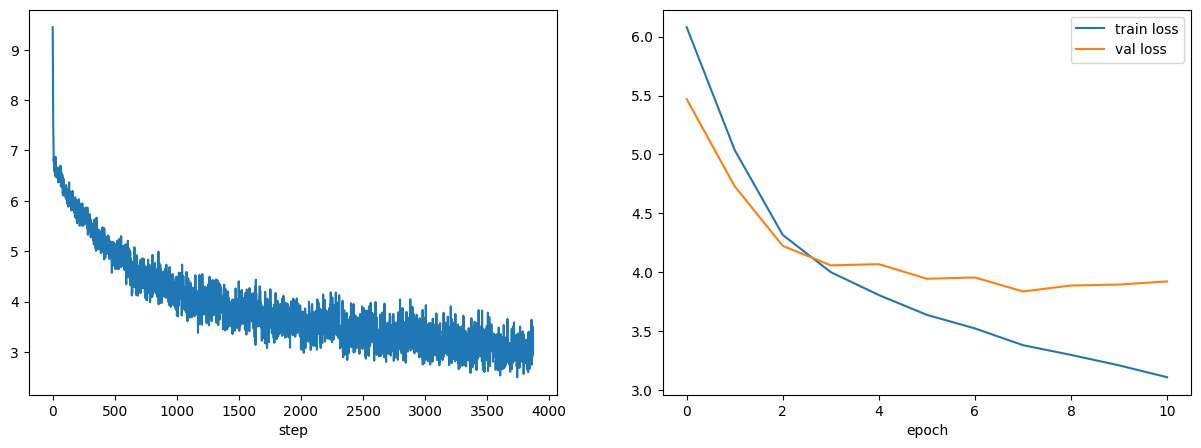

In [25]:
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

n_epochs = 10
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for trg, src in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(valid_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for trg, src in valid_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            valid_loss += loss.item()

    valid_loss /= len(valid_dataloader)
    valid_loss_history.append(valid_loss)
    torch.save(model.state_dict(), "rnn-with-attention")

In [26]:
from google.colab import files
files.download('rnn-with-attention')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# model = Seq2SeqAttention(enc, dec)
# model.load_state_dict(torch.load("rnn-attention", map_location=torch.device('cpu')))
# model.to(device)

In [29]:
import tqdm

In [32]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_dataloader)):
        src = batch[1]
        trg = batch[0]

        tmp = trg.clone().zero_().to(device)
        output = model(src.to(device), tmp, 0)
        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, trg_tokenizer) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, trg_tokenizer) for x in output[1:].detach().cpu().numpy().T])

40it [00:05,  6.79it/s]


In [33]:
bleu = corpus_bleu([[text] for text in original_text], generated_text)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 33.9


Удивительно, что без предобученных токенайзеров и с достаточно простой архитектурой мы смогли добиться качества в 30+ процентов

### Глава 5. С большой силой приходит большая ответственность

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super().__init__()

        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        density = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)

        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * density)
        pos_embedding[:, 1::2] = torch.cos(pos * density)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, trg_vocab_size, dim_feedforward = 512, dropout=0.1):
        super().__init__()

        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.src_token_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.trg_token_emb = TokenEmbedding(trg_vocab_size, emb_size)
        self.generator = nn.Linear(emb_size, trg_vocab_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask=None, trg_mask=None, src_padding_mask=None, trg_padding_mask=None, memory_key_padding_mask=None):
        src_emb = self.positional_encoding(self.src_token_emb(src))
        trg_emb = self.positional_encoding(self.trg_token_emb(trg))
        outs = self.transformer(src_emb, trg_emb, src_mask, trg_mask, None, src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask=None):
        return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

    def decode(self, trg, memory, trg_mask=None):
        return self.transformer.decoder(self.positional_encoding(self.trg_token_emb(trg)), memory, trg_mask)

In [ ]:
def generate_sub_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_masks(src, trg, device):
  src_seq_len = src.shape[0]
  trg_seq_len = trg.shape[0]
  trg_mask = generate_sub_mask(trg_seq_len, device)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)
  src_padding_mask = (src == src_pad_token_id).transpose(0, 1)
  trg_padding_mask = (trg == trg_pad_token_id).transpose(0, 1)
  return src_mask, trg_mask, src_padding_mask, trg_padding_mask

In [ ]:
def merge_tokens_and_hashes(tokens):
  if tokens == []:
    return []

  merged = [tokens[0]]

  for i in range(1, len(tokens)):
    if tokens[i][:2] == "##":
      merged[-1] += tokens[i][2:]
    # elif tokens[i].isdigit() and merged_tokens[-1].isdigit():
    #   merged_tokens[-1] += tokens[i]
    else:
      merged.append(tokens[i])

  return merged

In [ ]:
model = Seq2SeqTransformer(3, 3, 512, 8, src_tokenizer.get_vocab_size(), trg_tokenizer.get_vocab_size(), 512).to(device)
model.apply(init_weights)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
# model = Seq2SeqTransformer(3, 3, 512, 8, src_tokenizer.get_vocab_size(), trg_tokenizer.get_vocab_size(), 512)
# model.load_state_dict(torch.load("transformers", map_location=torch.device('cpu')))
# model.to(device)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_token_id)

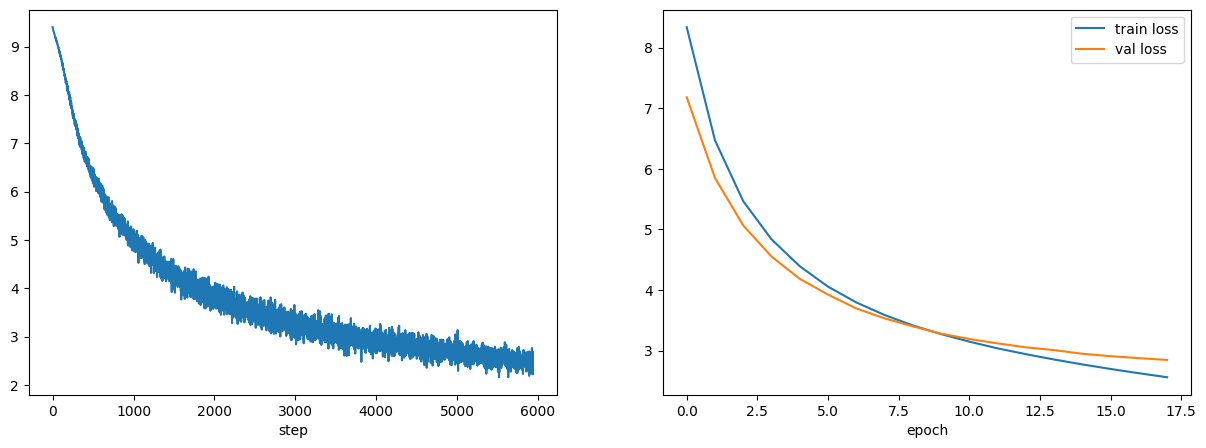

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

loss_history, train_loss_history, valid_loss_history = [], [], []
n_epochs = 36
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for trg, src in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        trg_input = trg[:-1, :]

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_masks(src, trg_input, device)

        output = model(src, trg_input, src_mask=src_mask, trg_mask=trg_mask, src_padding_mask=src_padding_mask, trg_padding_mask=trg_padding_mask, memory_key_padding_mask=src_padding_mask)

        output = output.view(-1, output.shape[-1])
        trg_out = trg[1:, :].view(-1)

        # print(output)

        loss = criterion(output, trg_out)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:

            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(valid_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for trg, src in valid_dataloader:
            src, trg = src.to(device), trg.to(device)
            trg_input = trg[:-1, :]

            src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_masks(src, trg_input, device)

            output = model(src, trg_input, src_mask=src_mask, trg_mask=trg_mask, src_padding_mask=src_padding_mask, trg_padding_mask=trg_padding_mask, memory_key_padding_mask=src_padding_mask)

            output = output.view(-1, output.shape[-1])
            trg_out = trg[1:, :].view(-1)

            loss = criterion(output, trg_out)

            valid_loss += loss.item()

    valid_loss /= len(valid_dataloader)
    valid_loss_history.append(valid_loss)

In [ ]:
original_text, generated_text = [], []
model.eval()

with torch.no_grad():
    for _, batch in tqdm.tqdm(enumerate(test_dataloader)):
        src = batch[1]
        trg = batch[0]
        trg_input = trg[:-1, :]
        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_masks(src, trg_input, device)
        output = model(src,
                       trg_input,
                       src_mask=src_mask,
                       trg_mask=trg_mask,
                       src_padding_mask=src_padding_mask,
                       trg_padding_mask=trg_padding_mask,
                       memory_key_padding_mask=src_padding_mask)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            original = trg[:, i]
            original_tokens = [trg_tokenizer.id_to_token(el) for el in original]
            original_tokens = [token for token in original_tokens if token not in specials]
            original_tokens = merge_tokens_and_hashes(original_tokens)
            original_text.append(original_tokens)

            generated = output[:, i]
            generated = [id_ for id_ in generated] # want to use index method
            if trg_eos_token_id in generated:
              generated = generated[:generated.index(trg_eos_token_id)]
            generated_tokens = [trg_tokenizer.id_to_token(el) for el in generated]
            generated_tokens = [token for token in generated_tokens if token not in specials]
            generated_tokens = merge_tokens_and_hashes(generated_tokens)
            generated_text.append(generated_tokens)

NameError: name 'model' is not defined

In [ ]:
bleu = corpus_bleu([[text] for text in original_text], generated_text)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 25.1


In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), "transformers")
# files.download('transformers')

Странно, что трансформер не смог показать похожего результата в 30-40 bleu. Как мы видим по переводу, качество тоже не идеальное, возможно, надо было поставить другое число эпох (хотя точность на валидации к ~30 шагу вышла на плато)